This will be a record of my additions to graham's analysis on his grass endophyte paper. 

[Getting data out R](#Rextract) 
- [Spatial dataframe](#spatDF)  
- [Diversity dataframe](#divDF)

[Cleaning data in python](#cleanup)  
[South-to-North diversity gradient](#NSDiv)  

## Getting data out R
<a id="Rextract"></a>

I'm not very efficient in R. Let's keep the R to a minimum, and use python where possible to clean and model data. Some analyses in R are inevitable, we'll come back to it as we need it. 

But to start, let's get graham's data into memory:

In [4]:
library(phyloseq)

biom97 <- import_biom('~/Documents/analyses/grahamGrass/grass-endophyte-community/grass_97_wmeta.biom')

We'll want the sample info to make maps and do spatial analysis:

In [2]:
write.csv(sample_data(biom97), file='grahamSample.csv')

As our [first task below](#NSDiv), we're doing an analysis of biodiversity as a function of latitude. To make comparisons of diversity among samples with very different read numbers, we'll need to rarify back to common numbers of reads. For the moment, we'll try the lowest number that let's us include all samples that are not controls (~7000 reads), and go up from there to 20,000 reads:

In [5]:
# get rid of controls
biom97_noCon = subset_samples(biom97, site != 'Control')

## split by host, with a few different read depths:
sampsizes = c(7000, 18000, 30000, 40000)
hosts = c("F. roemeri", "D. californica")

for (j in hosts){
    biom97.i = subset_samples(biom97_noCon, host == j)
    for (i in sampsizes){
        filename = paste(j,"diversity",i,".csv", sep='')
        biom97_rar.i = rarefy_even_depth(biom97.i, sample.size = i, rngseed = 1)
        aa <- estimate_richness(biom97_rar.i, measures=c('Simpson', 'Observed'))
        write.csv(aa, file=filename)
    }
}


`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

1718OTUs were removed because they are no longer 
present in any sample after random subsampling


...

`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

5 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


10grass11grass14grass15grass16grass

...

1371OTUs were removed because they are no longer 
present in any sample after random subsampling


...

`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

12 samples removedbecause they contained fewer reads than `sample.siz

## Cleaning data in python
<a id="cleanup"></a>

We need a dataframe that gives geographical location of each site in UTMs rather than lat/long. We also need to generate means and variance of the diversity of each site.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt; plt.ion()
from scipy import stats
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


<a id='spatDF'></a>
### Spatial dataframe

To get our by-site geographic information:

In [15]:
grahamSample = pd.read_csv('grahamSample.csv', index_col=0)
grahamSample.head()

,percent_sand,latitude,percent_C,WINTER.PRECIPITATION,region,SPRING.MAX.TEMPERATURE,ANNUAL.MIN.TEMPERATURE,total_N,stems,NO3,...,ANNUAL.PRECIPITATION,soil_pH,stems_browsed,C_to_N,elevation,percent_clay,seeds_produced,ANNUAL.MEAN.TEMPERATURE,SUMMER.DEWPOINT.TEMPERATURE,density
5grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,19.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1143.61,11.94,7.12,18.76
6grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,23.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1597.35,11.94,7.12,18.76
7grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,47.0,18.72,...,1599.87,7.51,3.0,0.02,448.0,30.2,2648.36,11.94,7.12,18.76
8grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,38.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1583.46,11.94,7.12,18.76
9grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,35.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1458.45,11.94,7.12,18.76


Seems like we have two latitudes for Hazel Dell:

In [16]:
grs = grahamSample.groupby('site')
print(grs.get_group('Hazel_Dell').latitude.unique())
print(grs.get_group('Hazel_Dell').longitude.unique())

[44.03 44.02]
[-123.22]


In [17]:
print(f'Total sites at latitude 44.03 = {sum(grahamSample.latitude == 44.03)}')
print(f'Total sites at latitude 44.02 = {sum(grahamSample.latitude == 44.02)}')

Total sites at latitude 44.03 = 12
Total sites at latitude 44.02 = 12


For the moment, we'll assume that the Hazel Dell sites all have the same latitude, that this is some sort of rounding error. We'll keep the more southern location, until someone tells us otherwise:

In [18]:
hd4403 = grahamSample.latitude == 44.03
grahamSample.latitude[hd4403] = 44.02

<ipython-input-18-f263d2f1635e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grahamSample.latitude[hd4403] = 44.02


I hate the slicing issue, always pops up. To make sure:

In [19]:
print(f'Total sites now at latitude 44.03 = {sum(grahamSample.latitude == 44.03)}')
print(f'Total sites now at latitude 44.02 = {sum(grahamSample.latitude == 44.02)}')

Total sites now at latitude 44.03 = 0
Total sites now at latitude 44.02 = 24


Looks like it worked. Subset to just the columns of interest:

In [21]:
aa = grahamSample[['site','latitude','longitude']]
bb = aa.reset_index(drop=True)
dd = bb.drop_duplicates()
dd.set_index('site', inplace=True)
ee = dd.drop('Control')
print(ee)

             latitude  longitude
site                            
French_flat     42.10    -123.63
Upper_Table     42.47    -122.88
Hazel_Dell      44.02    -123.22
Horse_Rock      44.30    -122.88
Upper_Weir      46.91    -122.71
Whidbey         48.21    -122.62
Roxy_Ann        42.35    -122.79
Whetstone       42.42    -122.91
Lower_Table     42.47    -122.95


Nice, but we want UTMs, and a proper geopandas df:

In [25]:
grahamSites = (gpd.GeoDataFrame(
    ee, geometry=gpd.points_from_xy(ee.longitude, ee.latitude))
    .drop(['latitude','longitude'], axis=1)
)

grahamSites.set_crs('EPSG:4326', inplace=True)
## reproject to UTM zone 10, which is EPSG:26710
grahamSites.to_crs('EPSG:26710', inplace=True)
grahamSites

,geometry
site,
French_flat,POINT (448002.580 4660874.730)
Upper_Table,POINT (509959.448 4701771.456)
Hazel_Dell,POINT (482462.948 4873918.789)
Horse_Rock,POINT (509667.410 4905002.198)
Upper_Weir,POINT (522179.104 5195005.240)
Whidbey,POINT (528326.591 5339512.618)
Roxy_Ann,POINT (517390.804 4688461.394)
Whetstone,POINT (507499.198 4696216.553)
Lower_Table,POINT (504205.130 4701765.701)


In [ ]:
#grahamSites.to_csv('grahamSiteCoords.csv')
## not a perfect export, have to modify with vim to get a good csv
## but works

## and maybe save us some work later:
#grahamSites.to_pickle('grahamSiteCoords.p')

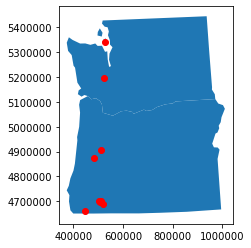

In [27]:
## check it on some maps. Here are some publicly available geojsons:
fig, ax = plt.subplots()
oregon = gpd.read_file('OR.geo.json')
oregon.to_crs('EPSG:26710', inplace=True)
washington = gpd.read_file('WA.geo.json')
washington.to_crs('EPSG:26710', inplace=True)
oregon.plot(ax=ax)
washington.plot(ax=ax)
grahamSites.plot(ax=ax, color='red')



Looks right...

<a id='divDF'></a>
### Diversity dataframe

Here is a function for cleaning up the csv's we got from the `phyloseq` `estimate_richness()` function:

In [2]:
def siteRichnessGPD(gpdDiv):
    ## convert diversity results
    aa = pd.read_csv(gpdDiv)
    aa.columns=['sampleName','Observed','Simpson']
    aa['sampleName'] = aa.sampleName.str.replace('X', '')
    aa.set_index('sampleName', inplace=True)
    ## convert sample data, just to get the site name and host
    bb = pd.read_csv('grahamSample.csv', index_col=0)
    bb = bb[['host','site', 'samplename']]
    ## bring our site geo info again:
    grahamSites = pd.read_pickle('grahamSiteCoords.p')
    ## attach name and host onto the diversity data
    dd = bb.merge(aa, left_index=True, right_index=True)
    ## make a gpdf
    grahamDivGPD = grahamSites.merge(dd, right_on='site', left_index=True)
    del(aa,bb,dd)
    aa = grahamDivGPD.groupby('site').mean()
    bb = grahamDivGPD.groupby('site').std()
    cc = aa.merge(bb, left_index=True, right_index=True)
    cc.columns = ['richness', 'simpson', 'richnessSD', 'simpsonSD']
    siteRichness = grahamSites.merge(cc, left_index=True, right_index=True)
    return(siteRichness)

In [3]:
def plotDiv(gpdRich, tit='', ax=None):
    if ax is not None: ax=ax
    if ax is None: fig, ax = plt.subplots()
    ax.errorbar(x=gpdRich['geometry'].y,
                y=gpdRich['richness'],
                yerr=gpdRich['richnessSD'],
                fmt='o',)
    ## ols line
    X = gpdRich['geometry'].y.to_numpy().reshape(-1,1)
    Y = gpdRich['richness'].to_numpy().reshape(-1,1)
    ax.plot( X, LinearRegression().fit(X, Y).predict(X),
            c='k', linewidth=2, #linestyle= "dotted",
            label='OLS linear regression model'
           )
    ## site labels:
    labs = gpdRich.index.to_series()
    xy = zip(gpdRich['geometry'].y, gpdRich['richness'])
    for i,j in enumerate(xy):
        ax.annotate(labs[i], xy=j)
    ## include linear regression results
    corStats = stats.linregress( gpdRich['geometry'].y, gpdRich['richness'])
    corString = (f'Pearson\'s r = {round(corStats[2],3)}, p = {round(corStats[3],3)}')
    top = ax.get_ylim()[1]
    right = ax.get_xlim()[1]
    ax.text(right, top, corString,
            horizontalalignment='right',
            verticalalignment='top')
    ax.set_title(tit)


So we can use these to look at our species richness trends...

## South-to-North diversity gradient]
<a id="NSDiv"></a>

There are some indications of a trend of increasing diversity of endophytes with latitude, especially with <i>Danthonia</i>

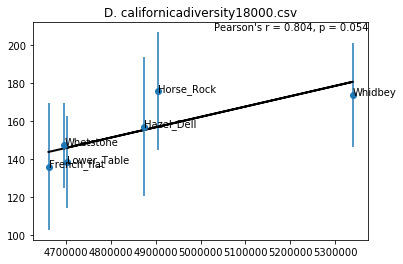

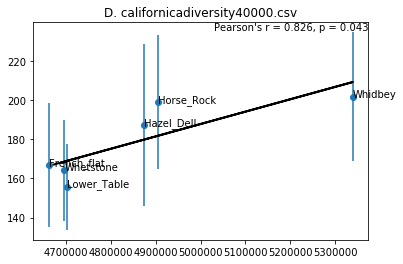

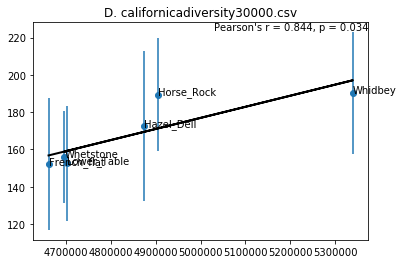

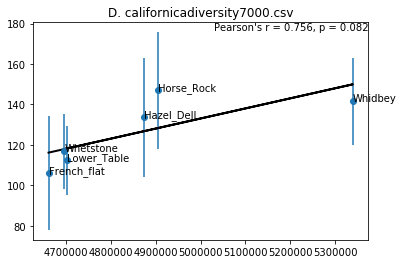

In [5]:
## look at the danthonia graphs:
gpdDiv_filenames = [ i for i in os.listdir() if "californicadiversity" in i ]

for i,j in enumerate(gpdDiv_filenames):
    gpdRich = siteRichnessGPD(j)
    plotDiv(gpdRich, tit=j)


The correlation is weaker and not statistically significant in <i>Festuca<i>.

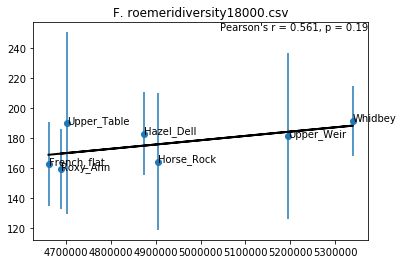

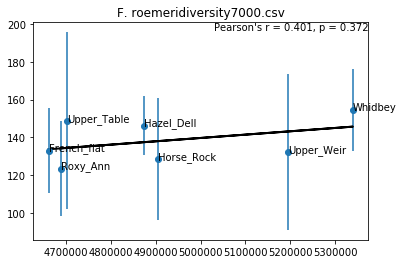

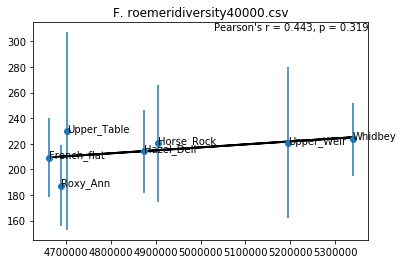

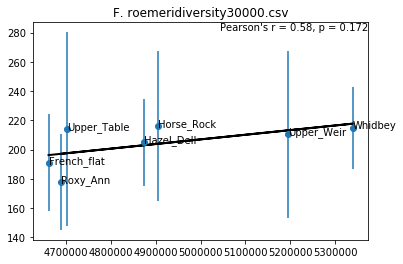

In [6]:
## look at the danthonia graphs:
gpdDiv_filenames = [ i for i in os.listdir() if "roemeridiversity" in i ]

for i,j in enumerate(gpdDiv_filenames):
    gpdRich = siteRichnessGPD(j)
    plotDiv(gpdRich, tit=j)
